In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch

from models import MLP
from datas import get_dataset_2d_regression

# Data Set

In [8]:
batch_size =32
trainset, trainloader, testset, testloader, classes = get_dataset_2d_regression(batch_size)
print(len(trainloader))

141


# Model

In [20]:
in_dim, out_dim, hidden_dim, num_hidden_layers = 2, 1, 8, 4
model = MLP(in_dim, out_dim, hidden_dim, num_hidden_layers)

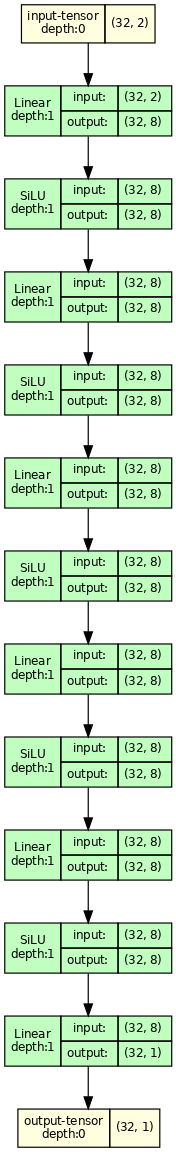

In [22]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size, in_dim), device='meta')
model_graph.visual_graph

# Train

In [11]:
def get_model_dtype(model):
    return next(model.parameters()).dtype

## Preprocessing
In regression setting, a preprocess would be needed. As we already know the mean = (0, 0) and diag(cov) = 33. The labels having mean  66.21, std 53.62

In [12]:
device = 'cuda'
model = model.to(device)
dtype = get_model_dtype(model)
losser = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
print(dtype)
num_epoch = 40

# label_mean = 66.21
# label_std = 53.62

# sample_mean = torch.tensor([0, 0], dtype=dtype, device=device,)
# sample_std = torch.tensor([5.773, 5.773], dtype=dtype, device=device,)

# def preprocess(samples, labels):
#     samples = (samples - sample_mean) / sample_std
#     labels = (labels - label_mean) / label_std
#     return samples, labels

# def denorm_pred(pred):
#     labels = pred * label_std + label_mean
#     return labels

torch.float32


In [13]:
epoch_eval_losses = []
epoch_train_avg_loss = []
batch_losses = []
for epoch in range(num_epoch):
    epoch_train_losses = []
    for batch in trainloader:
        samples, labels = batch
        samples = samples.to('cuda', dtype=dtype)
        labels = labels.to('cuda', dtype=dtype)
        # samples, labels = preprocess(samples, labels)

        pred = model(samples)[:, 0] # take the last output
        loss = losser(pred, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_train_losses.append(loss.item())
    
    eval_loss, num_samples = 0, 0
    for batch in testloader:
        with torch.no_grad():
            samples, labels = batch
            samples = samples.to('cuda', dtype=dtype)
            labels = labels.to('cuda', dtype=dtype)
            # samples, norm_labels = preprocess(samples, labels)
            pred = model(samples)[:, 0]
            # denormed_pred = denorm_pred(pred)
            # eval_loss += torch.square(pred - norm_labels).sum()
            eval_loss += torch.square(pred - labels).sum()
            num_samples += pred.shape[0]
    
    batch_losses.extend(epoch_train_losses) 
    epoch_train_avg_loss.append(np.mean(epoch_train_losses))
    epch_eval_loss = eval_loss / num_samples
    epoch_eval_losses.append(epch_eval_loss.item())

    print(f'epoch {epoch}, train avg loss {np.mean(epoch_train_losses): .02f}, eval error {epch_eval_loss: .02f}')

epoch 0, train avg loss  7120.49, eval error  5178.08
epoch 1, train avg loss  2050.43, eval error  1031.16
epoch 2, train avg loss  696.49, eval error  512.36
epoch 3, train avg loss  458.36, eval error  379.41
epoch 4, train avg loss  352.63, eval error  295.59
epoch 5, train avg loss  270.59, eval error  234.32
epoch 6, train avg loss  205.25, eval error  169.35
epoch 7, train avg loss  154.16, eval error  134.83
epoch 8, train avg loss  121.53, eval error  110.83
epoch 9, train avg loss  102.77, eval error  95.29
epoch 10, train avg loss  93.37, eval error  93.28
epoch 11, train avg loss  88.92, eval error  89.55
epoch 12, train avg loss  81.94, eval error  80.71
epoch 13, train avg loss  77.39, eval error  79.72
epoch 14, train avg loss  74.89, eval error  74.57
epoch 15, train avg loss  71.20, eval error  73.52
epoch 16, train avg loss  68.35, eval error  69.22
epoch 17, train avg loss  67.17, eval error  67.86
epoch 18, train avg loss  61.29, eval error  64.76
epoch 19, train av

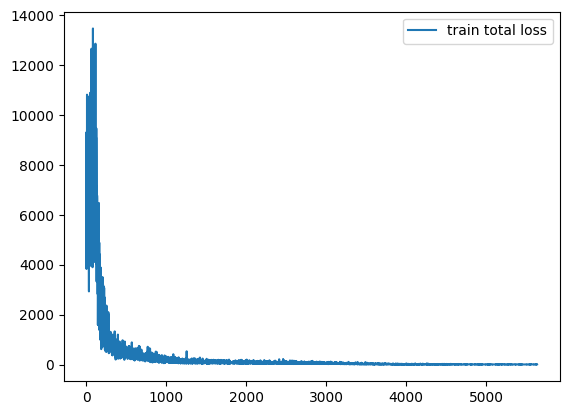

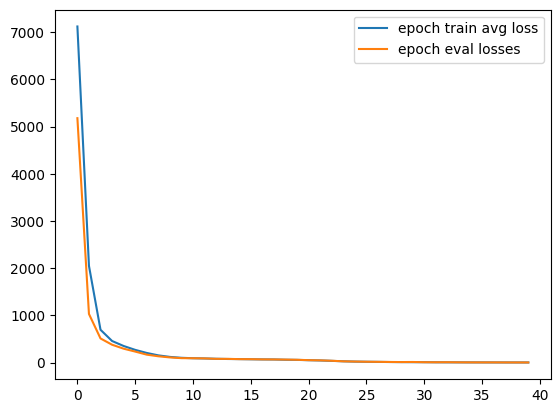

In [14]:
plt.plot(batch_losses, label='train total loss')
plt.legend()
plt.show()

plt.plot(epoch_train_avg_loss, label='epoch train avg loss')
plt.plot(epoch_eval_losses, label='epoch eval losses')
plt.legend()


# Show Data

In [15]:
train_samples = trainset.samples
train_labels = trainset.labels


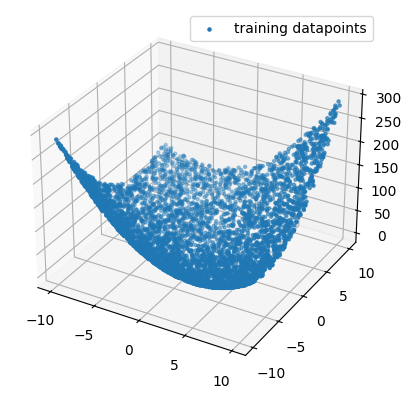

In [16]:
ax = plt.axes(projection='3d')
ax.scatter3D(train_samples[:, 0], train_samples[:, 1], train_labels, marker='.', label='training datapoints')
plt.legend()
plt.show()

In [17]:
testings = torch.tensor([])
for batch in testloader:
    with torch.no_grad():
        samples, labels = batch
        samples = samples.to('cuda', dtype=dtype)
        labels = labels.to('cuda', dtype=dtype)
        # samples, norm_labels = preprocess(samples, labels)
        pred = model(samples)
        testings_batch = torch.concat([samples.cpu(), pred.cpu()], dim=-1)
        testings = torch.concat([testings, testings_batch])

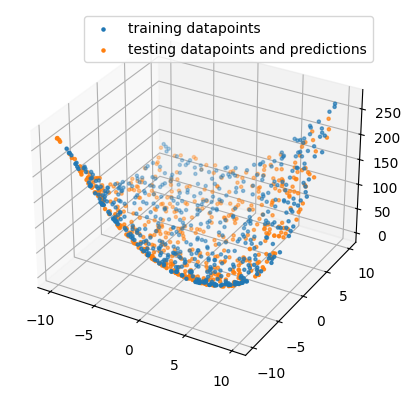

In [18]:
ax = plt.axes(projection='3d')
ax.scatter3D(train_samples[:500, 0], train_samples[:500, 1], train_labels[:500], marker='.', label='training datapoints')
ax.scatter3D(testings[:, 0], testings[:, 1], testings[:, 2], marker='.', label='testing datapoints and predictions')
plt.legend()
plt.show()